In [24]:
import numpy as np
from gurobipy import *
from scipy.stats import beta
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import time


In [2]:
start =time.clock()
#中间写上代码块

M = 2
#supply

N = 8
#demand

T = 4
#period

num_i = M
num_j = N
num_t = T

bar_I = np.array([1 for i in range(num_i)])
# I_binary,initial solution for benders

Z = np.array([(250*num_j)/num_i for i in range(num_i)])
# Z'i_capacity

demand = 200+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_t*num_j, 0.01), 2, 4)
zeta=demand.reshape(num_t,num_j)
for t in range(num_t):
    for j in range(num_j):
        zeta[t,j]=round(zeta[t,j],0)
#zeta=np.array([[0 for j in range(num_j)]for t in range(num_t)])
#demand1 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand2 = 400+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand3 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#demand4 = 100+10*beta.pdf(np.arange(0.01, 0.01+0.01*num_j, 0.01), 2, 4)
#for j in range(num_j):
#    zeta[0,j]=round(demand1[j],2)
#    zeta[1,j]=round(demand2[j],2)
#    zeta[2,j]=round(demand3[j],2)
#    zeta[3,j]=round(demand4[j],2)

zetau=zeta
#U'tj 需求均值

zetaup=1.1*zetau
#zetau'jt 需求上界

zetalow=0.9*zetau
#zetal'jt 需求下界

eta = 50
# eta_price

c =np.array([30 for i in range(num_i)])
# ci_productioncost

C =np.array([10 for j in range(num_j)])
# Cj_inventory cost

d= np.array([
[3,6,6,7,7,3,8,8],
[6,5,5,6,3,3,8,5]])
# dij_transportationcost

F= np.array([20 for i in range(num_i)])
#Fi_fixed construction cost

f=np.array([[0.8
    for j in range(num_j)]
    for t in range(num_t)])
#ftj_target of fill rate


R=10000
#target profit

num_k = 3
a = [0.3909, 0.01298,0]
b = [0, 0.8701, 1]
#piecewise linear function,k=3

epsilon=0.01


params = dict()
params["num_i"] = num_i
params["num_j"] = num_j
params["num_t"] = num_t
params["Z"] = Z
#params["P"] = P
params["zetau"] = zetau
params["zetaup"] = zetaup
params["zetalow"] = zetalow
params["eta"] = eta
params["c"] = c
params["C"] = C
params["d"] = d
params["F"] = F
params["f"] = f
params["R"] = R
params["a"] = a
params["b"] = b
params["epsilon"] = epsilon
params["bar_I"] = bar_I

In [3]:
mip = Model()
#决策变量
y = mip.addVars([t for t in range(num_t)],
                [i for i in range(num_i)], 
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="y")
P = mip.addVars([t for t in range(num_t)],
                [i for i in range(num_i)],
                vtype=GRB.CONTINUOUS, name="P")
I = mip.addVars([i for i in range(num_i)], 
                vtype=GRB.BINARY, name="I")

l = mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="l") 

D = mip.addVars([j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="D")

A = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="A") 
B = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="B")
g = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="g") 
h = mip.addVars([t for t in range(num_t)],
                [n for n in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="h") 
o = mip.addVars([t for t in range(num_t)], 
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="o")
s = mip.addVars([t for t in range(num_t)],
                [j for j in range(num_j)],
                vtype=GRB.CONTINUOUS, name="s")

#目标函数
mip.setObjective(
    (quicksum(D[j]
        for j in range(num_j))*eta
     -quicksum((d[i][j])*y[t,i,j]
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
     -quicksum(c[i]*P[t,i]
        for t in range(num_t)
        for i in range(num_i))
     -quicksum(F[i]*I[i] 
        for i in range(num_i))
     -quicksum(C[j]*l[t,j]
        for t in range(num_t)
        for j in range(num_j))
    ),GRB.MAXIMIZE
)

mip.update()

In [4]:
#约束
c0a=mip.addConstrs(
    (quicksum(
        -o[t,j]*zetaup[t,j]
        +s[t,j]*zetalow[t,j]
        for t in range(num_t))
     -D[j]
    )>=0
    for j in range(num_j)
)

c0b=mip.addConstrs(
    -o[t,j]+s[t,j]==1
    for j in range(num_j)
    for t in range(num_t)
)

c1 = mip.addConstrs(
    (D[j]
    -quicksum(y[t,i,j]
             for t in range(num_t)
             for i in range(num_i))
    )<=0
    for j in range(num_j)
)
#所有涉及n,t的地方都要+1         
                 
c3a=mip.addConstrs(
    quicksum(
        -g[t,n,j]*zetaup[n,j]+h[t,n,j]*zetalow[n,j]
        for n in range(t+1))
    +l[t,j]
    -quicksum(y[n,i,j]
             for n in range(t+1)
             for i in range(num_i))
    >= 0
    for j in range(num_j)
    for t in range(num_t)
)
#所有涉及n的地方都要+1

c3b=mip.addConstrs(
    -g[t,n,j]+h[t,n,j] == 1
    for j in range(num_j)
    for t in range(num_t)
    for n in range(t+1)
)    

c4 = mip.addConstrs( 
    quicksum(
        y[t,i,j] for j in range(num_j)
    ) <= P[t,i]
    for i in range(num_i)
    for t in range(num_t)
)

c5 = mip.addConstrs( 
    P[t,i]-Z[i]*I[i]<=0
    for i in range(num_i)
    for t in range(num_t)
)

mip.optimize()

# Print solution
print("Optimal solution of decision variables")
for v in mip.getVars():
    print (v.varName, v.x)

obj = mip.getObjective()
print("Objective value")
print(obj.getValue())


end = time.clock()
#print('Running time: %s Seconds'%(end-start))、
print((end-start))

Optimize a model with 176 rows, 690 columns and 808 nonzeros
Variable types: 688 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 128 rows and 584 columns
Presolve time: 0.00s
Presolved: 48 rows, 106 columns, 336 nonzeros
Variable types: 104 continuous, 2 integer (2 binary)

Root relaxation: objective 9.495781e+04, 45 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 94957.8120    0    2          - 94957.8120      -     -    0s
H    0     0                    94949.600000 94957.8120  0.01%     -    0s

Explored 1 nodes (45 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 94949.6 

Optimal solution found (tolerance 1.00e-04)
Best objective

In [22]:
fullfill=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fmean=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
fup=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
flow=np.array([[1.00 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        #fullfill[t,j]=sum(y[t,i,j] for i in range(num_i))
        fullfill[t,j]=max(sum(
            (sum(y[n,i,j].X for i in range(num_i))-zetau[n,j])
            for n in range(t)
        )+sum(y[t,i,j].X for i in range(num_i)),0)
        fmean[t,j]=round(fullfill[t,j]/zetau[t,j],2)
        fup[t,j]=round(fullfill[t,j]/zetaup[t,j],2)
        flow[t,j]=round(fullfill[t,j]/zetalow[t,j],2)
print("fullfilled demand")
print(fullfill)
print("actual demand")
print(zetau)
print("fill rate compared to mean of demand")
print(fmean)
print("fill rate compared to upper bound of demand")
print(fup)
print("fill rate compared to lower bound of demand")
print(flow)
###################################
L=np.array([[0 for j in range(num_j)]for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        L[t,j]=max(sum(
        (sum(
            y[n,i,j].x for i in range(num_i)
        )-zetau[n,j]) 
        for n in range(t+1)
    ),0)
print("Inventory level of each store")
print(L)  
###################################
profit=(
     sum(D[j].x
        for j in range(num_j))*eta
     -sum((d[i][j])*y[t,i,j].x
        for t in range(num_t)
        for i in range(num_i)
        for j in range(num_j))
     -sum(c[i]*P[t,i].x
        for t in range(num_t)
        for i in range(num_i))
     -sum(F[i]*I[i].x
        for i in range(num_i))
     -sum(C[j]*l[t,j].x
        for t in range(num_t)
        for j in range(num_j))
    )
print("profit")
print(profit)
#################################
num1=0
num2=0
num3=0
for t in range(num_t):
    for j in range(num_j):
        if fmean[t,j]<f[t,j]:
            num1+=1
        if fup[t,j]<f[t,j]:
            num2+=1
        if flow[t,j]<f[t,j]:
            num3+=1
per1=num1/(num_t*num_j)
per2=num2/(num_t*num_j)
per3=num3/(num_t*num_j)
print("violation probability")
print(per1)
print(per2) 
print(per3)
################################
LL=L.reshape(num_t*num_j,1).tolist()
print('upper inventory level')
print(max(LL))
print('average inventory level')
print(np.mean(LL))
##################################
vio=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
vioup=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
violow=np.array([[1.000 for j in range(num_j)] for t in range(num_t)])
for t in range(num_t):
    for j in range(num_j):
        vio[t,j]=max(f[t,j]-fmean[t,j],0.000)
        vioup[t,j]=max(f[t,j]-fup[t,j],0.000)
        violow[t,j]=max(f[t,j]-flow[t,j],0.000)
#没达到的程度        
viomean=np.mean(vio)
viostd=np.std(vio)
vioVaR = norm.ppf(1-0.99, viomean, viostd)
vioupmean=np.mean(vioup)
vioupstd=np.std(vioup)
vioupVaR = norm.ppf(1-0.99, vioupmean, vioupstd)
violowmean=np.mean(violow)
violowstd=np.std(violow)
violowVaR = norm.ppf(1-0.99, violowmean, violowstd)

print('mean/std/VaR compared to mean')
print(viomean)
print(viostd)
print(vioVaR)
print('mean/std/VaR compared to upper')
print(vioupmean)
print(vioupstd)
print(vioupVaR)
print('mean/std/VaR compared to lower')
print(violowmean)
print(violowstd)
print(violowVaR)



fullfilled demand
[[ 181.8  183.6  184.5  186.3  188.1  189.   189.9  190.8]
 [ 172.4  173.1  173.9  165.5  174.4  175.2  175.1  175.9]
 [ 155.5  156.1  155.9  155.7  156.3  156.1  156.   155.8]
 [ 135.4  135.   134.8  134.6  134.2  134.   133.   132.8]]
actual demand
[[ 202.  204.  205.  207.  209.  210.  211.  212.]
 [ 214.  215.  216.  216.  217.  218.  218.  219.]
 [ 219.  220.  220.  220.  221.  221.  221.  221.]
 [ 221.  221.  221.  221.  221.  221.  220.  220.]]
fill rate compared to mean of demand
[[ 0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9 ]
 [ 0.81  0.81  0.81  0.77  0.8   0.8   0.8   0.8 ]
 [ 0.71  0.71  0.71  0.71  0.71  0.71  0.71  0.7 ]
 [ 0.61  0.61  0.61  0.61  0.61  0.61  0.6   0.6 ]]
fill rate compared to upper bound of demand
[[ 0.82  0.82  0.82  0.82  0.82  0.82  0.82  0.82]
 [ 0.73  0.73  0.73  0.7   0.73  0.73  0.73  0.73]
 [ 0.65  0.65  0.64  0.64  0.64  0.64  0.64  0.64]
 [ 0.56  0.56  0.55  0.55  0.55  0.55  0.55  0.55]]
fill rate compared to lower bound o

[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], [0.81, 0.81, 0.81, 0.77, 0.8, 0.8, 0.8, 0.8], [0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.7], [0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.6, 0.6]]


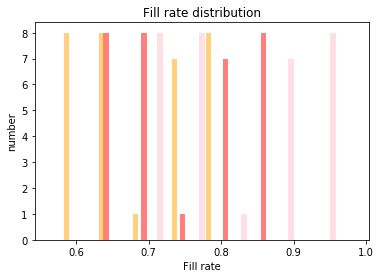

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
fillmean=fmean.tolist()
fillup=fup.tolist()
filllow=flow.tolist()
print(fillmean)
fp1=plt.hist(fillmean, bins=5, normed=0,facecolor='red', alpha=0.5,rwidth=0.5,label='a')  
fp2=plt.hist(fillup, bins=5, normed=0, facecolor='orange', alpha=0.5,rwidth=0.5,label='graph 2')
fp3=plt.hist(filllow, bins=5, normed=0, facecolor='pink', alpha=0.5,rwidth=0.5,label='graph 3')
plt.title('Fill rate distribution')
plt.xlabel('Fill rate')
plt.ylabel('number')
plt.show()
